# Goal
In order to optimize the inventory, I would like to know which films will be rented next month (September 2005) and I am asked to create a model to predict this.
## Instructions
1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

In [1]:
# import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)          # view all columns in jupyter
pd.set_option('display.max_rows', 150)                 # view max rows in jupyter

In [2]:
# 1. Create a query or queries to extract the information you think may be relevant for 
#    building the prediction model. It should include some film features and some rental 
#    features. Use the data from 2005.
# Information relevant to predict rentals in september 2005:
# - table rentals
# - table inventory (availability copies)
# - table film (film characteristics)
# - table film_category/category (popularity in september)
# - table payments (possibly correlated with amount)
# - table customer/address/city/country (extra customer characteristics)
import getpass  
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
# base query tested in MYSQL Workbench, more specified in instruction 2
query = '''
SELECT *
FROM sakila.rental AS r
JOIN sakila.inventory i USING (inventory_id)
JOIN sakila.film fi USING (film_id)
JOIN sakila.film_category fa USING (film_id)
JOIN sakila.customer cu USING (customer_id)
JOIN sakila.address a USING (address_id)
JOIN sakila.city ci USING (city_id)
JOIN sakila.country co USING (country_id)
WHERE rental_date < '2005-09-01 00:00:00' 
;
'''



········


In [3]:
# Test
#rentals = pd.read_sql_query(query, engine)
#rentals.head()

In [4]:
# 2. Create a query to get the list of films and a boolean indicating if it was rented 
#    last month (August 2005). This would be our target variable.
# - boolean as target for the model: t_rented
query = '''
SELECT r.rental_id, r.rental_date, CONCAT(fi.title, r.inventory_id) AS inventory_id, r.customer_id, r.return_date, 
r.staff_id, i.film_id, CONCAT('Store',i.store_id) AS store_id, 
concat(fi.rental_duration,'days') AS rental_duration, REPLACE(fi.rental_rate, '.', 'd') AS rental_rate, fi.length, fi.rating, 
concat(ca.name,fc.category_id) AS category,
CASE
    WHEN rental_date >= '2005-08-01 00:00:00' THEN 1
    ELSE 0
END AS t_rented
FROM sakila.rental AS r
JOIN sakila.inventory i USING (inventory_id)
JOIN sakila.film fi USING (film_id)
JOIN sakila.film_category fc USING (film_id)
JOIN sakila.category ca USING (category_id)
JOIN sakila.customer cu USING (customer_id)
-- JOIN sakila.address a USING (address_id)
-- JOIN sakila.city ci USING (city_id)
-- JOIN sakila.country co USING (country_id)
WHERE rental_date < '2005-09-01 00:00:00' 
-- AND rental_date > '2005-07-31 23:59:59'
;
'''

In [5]:
# 3. Read the data into a Pandas dataframe.
rentals = pd.read_sql_query(query, engine)
rentals.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,film_id,store_id,rental_duration,rental_rate,length,rating,category,t_rented
0,10895,2005-08-02 01:16:59,AMADEUS HOLY93,77,2005-08-03 02:41:59,2,19,Store1,6days,0d99,113,PG,Action1,1
1,12268,2005-08-18 04:26:54,AMADEUS HOLY93,39,2005-08-23 06:40:54,2,19,Store1,6days,0d99,113,PG,Action1,1
2,3150,2005-06-20 20:35:28,AMADEUS HOLY94,34,2005-06-26 01:01:28,1,19,Store1,6days,0d99,113,PG,Action1,0
3,5072,2005-07-09 05:01:58,AMADEUS HOLY94,254,2005-07-18 08:17:58,2,19,Store1,6days,0d99,113,PG,Action1,0
4,9080,2005-07-30 08:02:39,AMADEUS HOLY94,276,2005-08-06 12:02:39,1,19,Store1,6days,0d99,113,PG,Action1,0


In [6]:
# 4. Analyze extracted features and transform them. You may need to encode some categorical 
#    variables, or scale numerical variables.
print('Number of rows:', rentals.shape[0])
print('Number of columns', rentals.shape[1])
rentals.dtypes

Number of rows: 15862
Number of columns 14


rental_id                   int64
rental_date        datetime64[ns]
inventory_id               object
customer_id                 int64
return_date        datetime64[ns]
staff_id                    int64
film_id                     int64
store_id                   object
rental_duration            object
rental_rate                object
length                      int64
rating                     object
category                   object
t_rented                    int64
dtype: object

In [7]:
# First exploration (changed SQL statement accordingly):
# - many duplicate colums: made * in SELECT statement more specific
# - To be dropped, not usable for the model: decription, original_language_id, replacement_cost, location

In [8]:
# Which is unclear in this assignment, is the assumption 
# that customers who rented in August also would rent in 
# september and therefore. I assume that the transactions
# before August should not be ignored

In [9]:
# All features which contain NaN
rentals.isna().sum()

rental_id          0
rental_date        0
inventory_id       0
customer_id        0
return_date        1
staff_id           0
film_id            0
store_id           0
rental_duration    0
rental_rate        0
length             0
rating             0
category           0
t_rented           0
dtype: int64

In [10]:
# Set return_date with NaT on Sept 1st
end = pd.to_datetime('2005-09-01')
rentals['return_date'] = rentals['return_date'].fillna(end)

In [11]:
# change contents with '-' to avoid problems at encoding --> column names
# rating and category

def clean_encoding(x):
    x = x.replace(".", '')
    x = x.replace("-", '')
    return x

rentals['rating'] = rentals['rating'].apply(clean_encoding)
rentals['category'] = rentals['category'].apply(clean_encoding)

In [12]:
# Rentals in August
rentals['t_rented'].loc[rentals['t_rented'] == 1].count()  # 5686 rentals in august

5686

In [13]:
rentals.head(100)

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,film_id,store_id,rental_duration,rental_rate,length,rating,category,t_rented
0,10895,2005-08-02 01:16:59,AMADEUS HOLY93,77,2005-08-03 02:41:59,2,19,Store1,6days,0d99,113,PG,Action1,1
1,12268,2005-08-18 04:26:54,AMADEUS HOLY93,39,2005-08-23 06:40:54,2,19,Store1,6days,0d99,113,PG,Action1,1
2,3150,2005-06-20 20:35:28,AMADEUS HOLY94,34,2005-06-26 01:01:28,1,19,Store1,6days,0d99,113,PG,Action1,0
3,5072,2005-07-09 05:01:58,AMADEUS HOLY94,254,2005-07-18 08:17:58,2,19,Store1,6days,0d99,113,PG,Action1,0
4,9080,2005-07-30 08:02:39,AMADEUS HOLY94,276,2005-08-06 12:02:39,1,19,Store1,6days,0d99,113,PG,Action1,0
5,14603,2005-08-21 17:51:06,AMADEUS HOLY94,26,2005-08-28 15:36:06,1,19,Store1,6days,0d99,113,PG,Action1,1
6,588,2005-05-28 12:08:37,AMADEUS HOLY95,89,2005-05-29 16:25:37,2,19,Store1,6days,0d99,113,PG,Action1,0
7,2867,2005-06-20 00:08:38,AMADEUS HOLY95,483,2005-06-23 19:35:38,1,19,Store1,6days,0d99,113,PG,Action1,0
8,6030,2005-07-11 02:37:51,AMADEUS HOLY95,36,2005-07-16 22:34:51,2,19,Store1,6days,0d99,113,PG,Action1,0
9,7788,2005-07-28 07:21:55,AMADEUS HOLY95,487,2005-08-03 06:33:55,1,19,Store1,6days,0d99,113,PG,Action1,0


# Explore multi-classification

This is where I can find classes in the data with often a wider range of classes than only A en B. 

<br>

<details><summary>▶ Basic exploration tools:</summary>
<p>

| in SQL | in pandas | example|
|---|---|---|
| COUNT DISTINCT | .nunique() | superstore['Country'].nunique() |
| DISTINCT | .unique() | superstore['Country'].unique() |
| GROUP BY  with COUNT | .value_counts() | superstore['Country'].value_counts() |
| no NULL values | .value_counts(dropna=False) | superstore['Country'].value_counts(dropna=False) |

</p>
</details>



In [14]:
# Explore multi-class classification: 
# wider range of classes than only A en B
rentals['length'].value_counts()           # Conclusion: high variance of values, no classification
# DROPPED rentals['language_id'].value_counts()      # Conclusion: only one language, better drop in SQL
# DROPPED rentals['release_year'].value_counts()     # Conclusion: only one release year, better drop in SQL
# DROPPED rentals['city_id'].value_counts()          # not really numeric, is an id for something categorical with too wide spread, decide to drop it
# DROPPED all address features and decide top keep store_id
rentals['rental_duration'].value_counts()  # Conclusion: equally classified 3-7 days
rentals['rating'].value_counts()           # Conclusion: equally classified over all different ratings
rentals['store_id'].value_counts()         # Conclusion: equally classified over 2 stores
rentals['category'].value_counts()      # Conclusion: equally classified over 16 categories - concat in select
# rentals['rental_rate'].value_counts()      # Conclusion: equally classified over 3 rates
# rentals['inventory_id'].value_counts() # sounds relevant for inventory analysis, keep in df, not for input model


Sports15        1164
Animation2      1145
Action1         1095
SciFi14         1093
Family8         1083
Drama7          1053
Documentary6    1044
Foreign9        1022
Games10          955
Children3        939
Comedy5          932
Classics4        930
New13            927
Horror11         834
Travel16         827
Music12          819
Name: category, dtype: int64

In [15]:
# print(rentals['last_update'].min(),' | ', rentals['last_update'].max())
# 2006-02-15 21:30:53  |  2006-02-23 04:12:08
# Conclusion: values of last_update are all outside time window of this assignment
# Decision to remove last_update from SELECT statement 

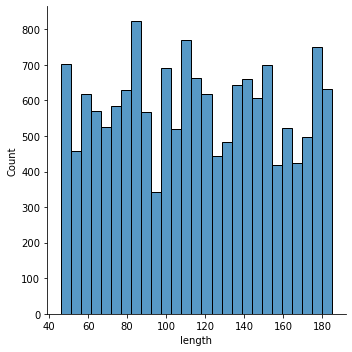

More or less equally devided between  46  and  185 minutes.


In [16]:
# Closer look at length
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.displot(rentals['length'])
plt.show()

print("More or less equally devided between ",rentals['length'].min()," and ",rentals['length'].max(), 'minutes.')
# dropping or binning ??

In [17]:
# For experimenting with date format I want to split it in three vars: dd mm yyyy
rentals['day'] = rentals['rental_date'].dt.day
rentals['month'] = rentals['rental_date'].dt.month
# rentals['year'] = rentals['rental_date'].dt.year   # take this out, seems to be only one year
rentals.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,film_id,store_id,rental_duration,rental_rate,length,rating,category,t_rented,day,month
0,10895,2005-08-02 01:16:59,AMADEUS HOLY93,77,2005-08-03 02:41:59,2,19,Store1,6days,0d99,113,PG,Action1,1,2,8
1,12268,2005-08-18 04:26:54,AMADEUS HOLY93,39,2005-08-23 06:40:54,2,19,Store1,6days,0d99,113,PG,Action1,1,18,8
2,3150,2005-06-20 20:35:28,AMADEUS HOLY94,34,2005-06-26 01:01:28,1,19,Store1,6days,0d99,113,PG,Action1,0,20,6
3,5072,2005-07-09 05:01:58,AMADEUS HOLY94,254,2005-07-18 08:17:58,2,19,Store1,6days,0d99,113,PG,Action1,0,9,7
4,9080,2005-07-30 08:02:39,AMADEUS HOLY94,276,2005-08-06 12:02:39,1,19,Store1,6days,0d99,113,PG,Action1,0,30,7


In [18]:
# After exploration, I decide to start building the model with following features
# When features don't appear in the final result, I decided to drop them
# - rating
# - store_id
# - rental_duration
# - length
# - rating
# - rental_rate
# - category_id
# day / month / year (of rental_date)
#
# A unique identifier for inventory 
# - inventory_id  (still not sure what to do with it)
#
# This will be done on the target
# - t_rented

# adjust dataset accordingly
# Deleting several columns with a list/function
list_cols = ["rental_id", "rental_date", "customer_id", "return_date", "staff_id", "film_id"]

def cols_del(cols):
    for x in cols:
        global rentals                 # function should not turn default vars into local
        exist_col = x in rentals
        if exist_col == True:                                 # no error when re-run code
            rentals = rentals.drop(labels=x, axis=1)

cols_del(list_cols)           # Function to deleting several columns with a list/function

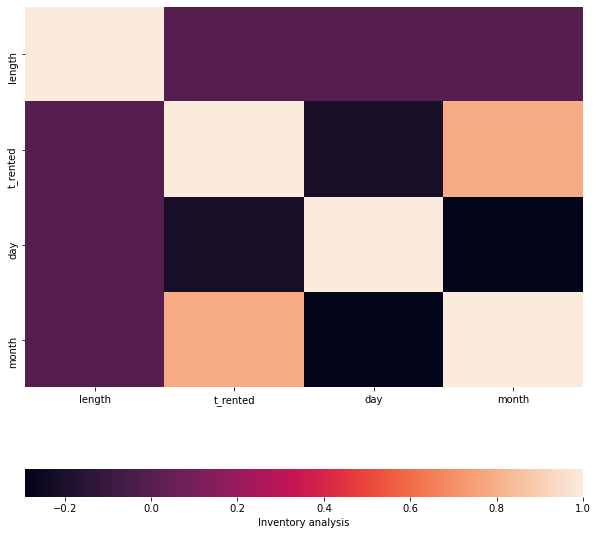

In [19]:
# Visual exploration of correlation with the heatmap
# Before collinearity drops
correlations_matrix = rentals.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(correlations_matrix, cbar_kws={'label': 'Inventory analysis', 'orientation': 'horizontal'}, annot=False)
plt.show()

In [20]:
# Conclusion: not so enthusiastic about the correlations
# Probably not a good idea to use / split up rental date, since it is already 
# in target t_rented (redundancy)
rentals = rentals.drop(labels='day', axis=1)
rentals = rentals.drop(labels='month', axis=1)

In [21]:
# on second thought it is still better to display the ids as categoricals rather than numerical
# change SELECT statement accordingly
rentals

,inventory_id,store_id,rental_duration,rental_rate,length,rating,category,t_rented
0,AMADEUS HOLY93,Store1,6days,0d99,113,PG,Action1,1
1,AMADEUS HOLY93,Store1,6days,0d99,113,PG,Action1,1
2,AMADEUS HOLY94,Store1,6days,0d99,113,PG,Action1,0
3,AMADEUS HOLY94,Store1,6days,0d99,113,PG,Action1,0
4,AMADEUS HOLY94,Store1,6days,0d99,113,PG,Action1,0
...,...,...,...,...,...,...,...,...
15857,WORKING MICROCOSMOS4535,Store2,4days,4d99,74,R,Travel16,0
15858,WORKING MICROCOSMOS4535,Store2,4days,4d99,74,R,Travel16,0
15859,WORKING MICROCOSMOS4535,Store2,4days,4d99,74,R,Travel16,0
15860,WORKING MICROCOSMOS4535,Store2,4days,4d99,74,R,Travel16,0


In [22]:
rentals.dtypes
# in the end I changed some features into object, because the're more like
# categorical and need to be treated like that

inventory_id       object
store_id           object
rental_duration    object
rental_rate        object
length              int64
rating             object
category           object
t_rented            int64
dtype: object

In [23]:
# Prepare for building
# 
# park for later use
park_inv_id = rentals[['inventory_id']]
rentals = rentals.drop(labels='inventory_id', axis=1)
#
# X/Y Split: removing label (target) from the features (data)
# creating input (y,X) for sklearn - train_test_split
y = rentals[['t_rented']]
X = rentals.drop(['t_rented'], axis=1)

In [24]:
# Splitting the train and test data before transformations
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [25]:
# for keep track of the train / test flow
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12689, 6)
(3173, 6)
(12689, 1)
(3173, 1)


In [26]:
# Dealing with the numericals using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)       # split numeric

MinMaxtransformer = MinMaxScaler().fit(X_train_num)
X_normalized = MinMaxtransformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_normalized, columns = X_train_num.columns)
# X_train_norm

In [27]:
# Dealing with the categoricals using get_dummies

X_train_categorical = X_train.select_dtypes(include = object)  # split categorical

X_train_cat = pd.get_dummies(X_train_categorical,
                            columns = ['store_id', 'rental_duration', 'rental_rate', 'rating', 'category'],
                            drop_first = True)
# X_train_cat

In [28]:
# Stitching NUM and CAT back together at TRAIN set
X_train_transformed = np.concatenate((X_train_norm, X_train_cat), axis=1)
# X_train_transformed    # numpy array

In [29]:
# 5. Create a logistic regression model to predict this variable from the cleaned data.
from sklearn.linear_model import LogisticRegression
# import warnings
# warnings.filterwarnings('ignore')

model_1 = LogisticRegression(random_state=0, solver='saga',                        # saga
                  multi_class='multinomial').fit(X_train_transformed, y_train)

model_2 = LogisticRegression(random_state=0, solver='lbfgs',                       # lbfgs
                  multi_class='multinomial').fit(X_train_transformed, y_train)

/Users/rene/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/rene/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [30]:
# Do the same with TEST data
# NUM
X_test_num = X_test.select_dtypes(include = np.number)
X_normalized = MinMaxtransformer.transform(X_test_num)        # Same transformer!
X_test_norm = pd.DataFrame(X_normalized, columns = X_test_num.columns)
# CAT
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical,
                            columns = ['store_id', 'rental_duration', 'rental_rate', 'rating', 'category'],
                            drop_first = True)
# GetDummies check - are TRAIN and TEST aligned?
# display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))

In [31]:
# Stitching NUM and CAT back together at TEST set
X_test_transformed = np.concatenate((X_test_norm, X_test_cat), axis=1)

In [32]:
# Using the regression models and test data

pred_model_1 = model_1.predict(X_test_transformed)
display(model_1.score(X_test_transformed, y_test))

pred_model_2 = model_2.predict(X_test_transformed)
display(model_2.score(X_test_transformed, y_test))


0.6501733375354554

0.6501733375354554

In [33]:
# 6. Evaluate the results.
from sklearn.metrics import confusion_matrix

# Model I
display(confusion_matrix(y_test, pred_model_1))

# Model II
display(confusion_matrix(y_test, pred_model_2))


array([[2063,    0],
       [1110,    0]])

array([[2063,    0],
       [1110,    0]])

In [34]:
# There is no different effect in both models